In [747]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import glob
from datetime import datetime, timedelta
import os
from skimage import io
from skimage import transform
from skimage.filters import  gaussian
from skimage.morphology import disk, remove_small_holes, binary_erosion
from skimage.color import rgb2hsv, hsv2rgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 

# Load an example image

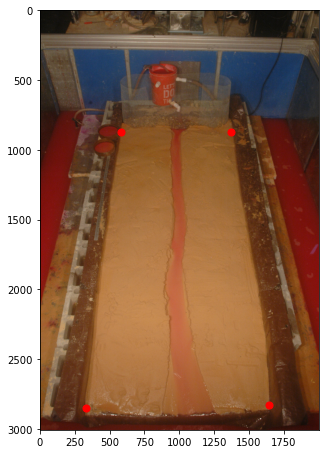

In [1174]:
i = 0

flist = glob.glob(os.path.join('example_data', 'photo_example', '*.jpg'))
raw_image = io.imread(flist[i])

# Show image
fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow(raw_image)


dst = np.array([[585, 870], [1370, 870], [1640, 2830], [330, 2850]])
ax.scatter(dst[:, 0], dst[:,1], c='r', s=50)

# Orthorectify image and crop

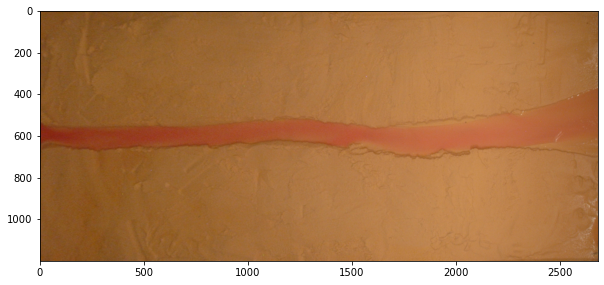

In [1175]:
src = np.array([[0, 1200], [0, 0], [2680, 0], [2680, 1200]])
dst = np.array([[585, 870], [1370, 870], [1640, 2830], [330, 2850]])

tform3 = transform.ProjectiveTransform()
tform3.estimate(src, dst)
rectified_image = transform.warp(raw_image, tform3, output_shape=(1200, 2680))
#rectified_image = rectified_image[150:1350]

# Show image
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(rectified_image)

# Calculate depth proxy

The algorithm for calculating the depth proxy involves several steps. First we convert to HSV (hue, saturation, value) and ignore the value component. This is equivalent to correcting for brightness variation across the image.

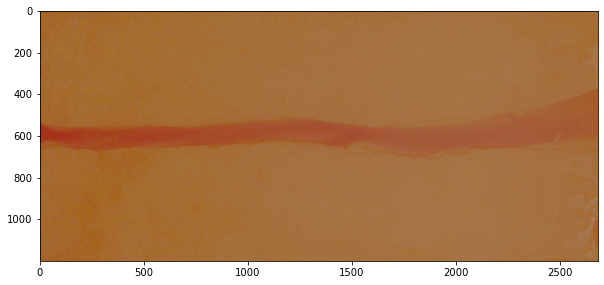

In [1176]:
hsv = rgb2hsv(rectified_image) # calculate HSV from RGB
hsv[:,:,2] = 0.65 # set v to a constant value

# convert back to RGB
corrected_image = hsv2rgb(hsv)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(corrected_image)

The red band is the brightest in all pixels and in all images. Because $V = max(R, G, B)$, color differences are reduced to blue and green bands.

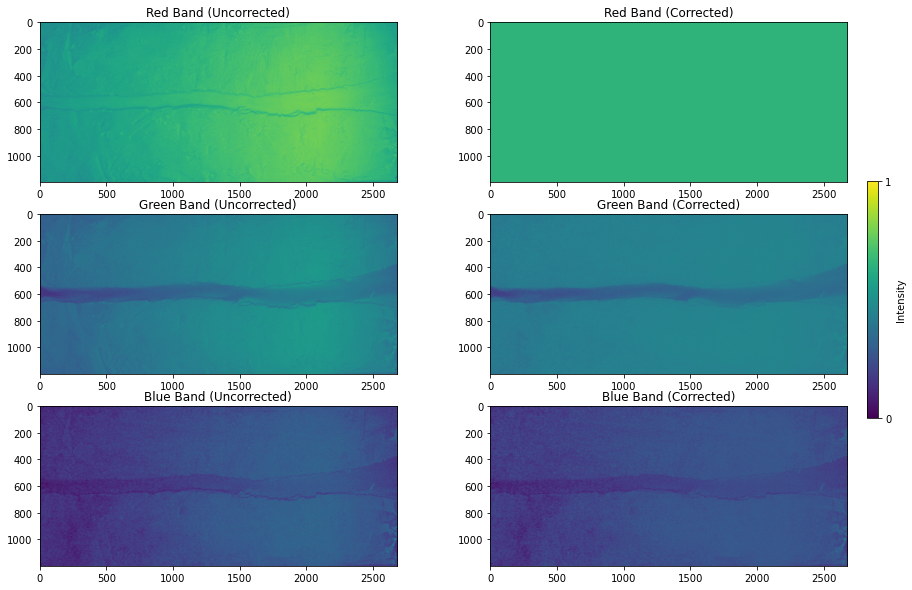

In [1177]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

plt.subplots_adjust(right=0.89)
cax = plt.axes([0.9, 0.33, 0.01, 0.33])

# make colorbar
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
cb1.set_label('Intensity')
cb1.set_ticks([0, 1])
cb1.set_ticklabels([0,1])

ax[0,0].set_title('Red Band (Uncorrected)')
ax[0,0].imshow(rectified_image[:,:,0], vmin=0, vmax=1)

ax[0,1].set_title('Red Band (Corrected)')
ax[0,1].imshow(corrected_image[:,:,0], vmin=0, vmax=1)

ax[1,0].set_title('Green Band (Uncorrected)')
ax[1,0].imshow(rectified_image[:,:,1], vmin=0, vmax=1)

ax[1,1].set_title('Green Band (Corrected)')
ax[1,1].imshow(corrected_image[:,:,1], vmin=0, vmax=1)

ax[2,0].set_title('Blue Band (Uncorrected)')
ax[2,0].imshow(rectified_image[:,:,2], vmin=0, vmax=1)

ax[2,1].set_title('Blue Band (Corrected)')
ax[2,1].imshow(corrected_image[:,:,2], vmin=0, vmax=1)

A linear transformation reveals a distinct difference between wet and dry pixels.

In [1231]:
# Make 1D vectors of red, green, and blue for plotting
rvec = corrected_image[:,:,0].reshape(corrected_image.shape[0] * corrected_image.shape[1]) # Red
gvec = corrected_image[:,:,1].reshape(corrected_image.shape[0] * corrected_image.shape[1]) # Green
bvec = corrected_image[:,:,2].reshape(corrected_image.shape[0] * corrected_image.shape[1]) # Blue
rgbvec = np.vstack((rvec, gvec, bvec)).T

# Define color reference points 
threshold_reference = np.array([0.41, 0.21])
theta = -2.7

unitvec = np.array([np.cos(theta), -np.sin(theta)])

proxy = gvec * np.cos(theta) - bvec * np.sin(theta)
threshold = threshold_reference[0] * np.cos(theta) - threshold_reference[1] * np.sin(theta)
norm = gvec * np.sin(theta) + bvec * np.cos(theta)
proxy = proxy - threshold
norm = norm - np.nanmean(norm)

proxyarr = proxy.reshape(corrected_image.shape[:-1])
proxyarr = gaussian(proxyarr, 5)

wet = remove_small_holes(~remove_small_holes(proxyarr<0, area_threshold=20*2688), area_threshold=200)
proxyarr[~wet] = 0

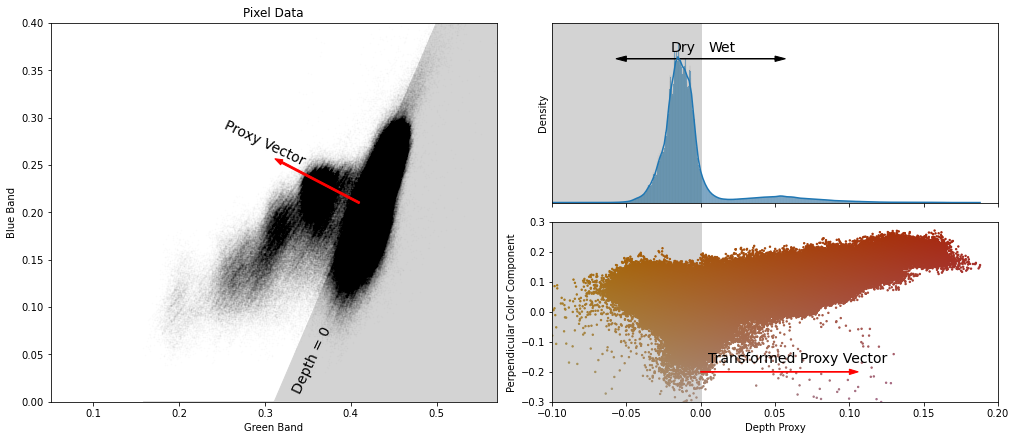

In [1233]:
fig = plt.figure(constrained_layout=True, figsize=(14,6))
gs = mpl.gridspec.GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[0, 1])
ax = [ax1, ax2, ax3]

angle = 180 - np.rad2deg(theta)

ax[0].set_title('Pixel Data')
ax[0].text(0.25, 0.25, 'Proxy Vector', rotation=angle, size=14)
ax[0].text(0.33, 0.01, 'Depth = 0', rotation=angle+90, size=14)
ax[0].text(0.4, 0.07, '', size=14)
ax[0].scatter(gvec, bvec, s=0.5, c='k', alpha=0.01)#, c=rgbvec)

ax[0].arrow(threshold_reference[0], threshold_reference[1], unitvec[0]/10, unitvec[1]/10, color='red', width=0.002)

theta_classifier = theta + np.pi/2
unitvec_classifier = np.array([np.cos(theta_classifier), -np.sin(theta_classifier)])
p2 = np.array(threshold_reference) + unitvec_classifier
m = (p2[1] - threshold_reference[1]) / (p2[0] - threshold_reference[0])
b = p2[1] - m * p2[0]
xvals = np.linspace(np.nanmin(gvec), np.nanmax(gvec))
classifier = m * xvals + b

ax[0].fill_between(xvals, 0, classifier, color='lightgrey', lw=1, zorder=0)

ax[0].set_ylim(0, 0.4)
ax[0].set_xlim(0.05, 0.57)

ax[0].set_xlabel('Green Band')
ax[0].set_ylabel('Blue Band')

ax[1].set_ylim(-0.3, 0.3)
ax[1].set_xlim(-0.1, 0.2)
ax[1].scatter(proxy, norm, s=2, c=rgbvec)
ax[1].fill_between(np.linspace(-0.2, 0), np.ones(50)*-0.3, np.ones(50) * 0.3, color='lightgrey', lw=1, zorder=0)
ax[1].text(0.005, -0.17, 'Transformed Proxy Vector', size=14)

ax[1].set_xlabel('Depth Proxy')
ax[1].set_ylabel('Perpendicular Color Component')
ax[1].arrow(0, -0.2, 0.1, 0, color='red', width=0.002, head_width=0.018, head_length = 0.006)

ax[2].set_ylim(0, 50)
ax[2].set_xlim(-0.1, 0.2)

ax[2].fill_between(np.linspace(-0.2, 0), np.zeros(50), np.ones(50) * 50, color='lightgrey', lw=1, zorder=0)
sns.histplot(proxy, ax=ax[2], kde=True, stat='density')
_ = ax[2].set_yticks([])
_ = ax[2].set_xticklabels([])
_ = ax[2].text(-0.02, 42, 'Dry', size=14)
ax[2].arrow(0, 40, -0.05, 0, head_width=1.5, head_length=0.007, color='black')
_ = ax[2].text(0.005, 42, 'Wet', size=14)
ax[2].arrow(0, 40, 0.05, 0, head_width=1.5, head_length=0.007, color='black')

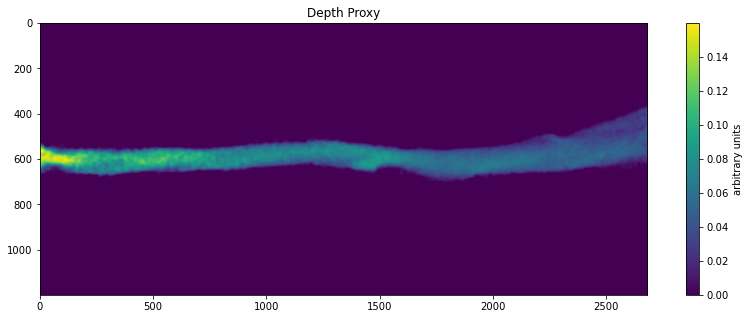

In [1185]:
fig, ax = plt.subplots(figsize=(14,5))
im1 = ax.imshow(proxyarr)
cb1 = plt.colorbar(im1, ax=ax)
ax.set_title('Depth Proxy')
cb1.set_label('arbitrary units')

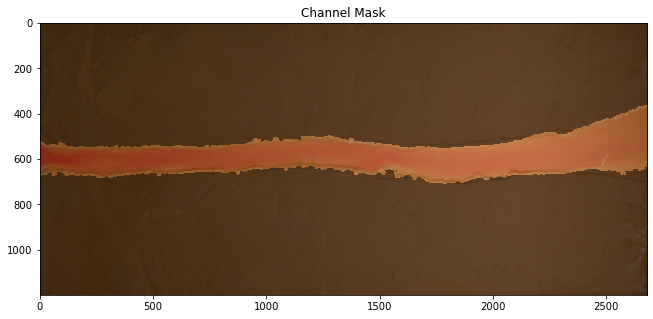

In [1184]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(rectified_image)
ax.set_title('Channel Mask')
masked = np.ma.masked_where(wet, np.ones_like(wet))
ax.imshow(masked,alpha=0.5, cmap='Greys_r')